In [1]:
# Imports.
import pickle
import numpy as np
import tensorflow as tf
import tensorflow.keras
import matplotlib
import matplotlib.pyplot as plt


# Set up GPU.
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)


# Load in the dataset.
dataset = tf.keras.datasets.mnist


# Split the dataset into training, validation and testing data.
(x_train, y_train), (x_test, y_test) = dataset.load_data()
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], x_train.shape[2], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], x_test.shape[2], 1))
x_validation = x_test[:5000,...]
x_test = x_test[5000:,...]
y_validation = y_test[:5000,...]
y_test = y_test[5000:,...]


#  Convert the y values to categorical.
y_train = tf.keras.utils.to_categorical(y_train)
y_validation = tf.keras.utils.to_categorical(y_validation)
y_test = tf.keras.utils.to_categorical(y_test)
print(x_train.shape, x_validation.shape, x_test.shape, y_train.shape, y_validation.shape, y_test.shape)


# Normalise the data.
x_train = x_train / 255.0
x_validation = x_validation / 255.0
x_test = x_test / 255.0


# Build the neural network.
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(filters=6, kernel_size=(3, 3), activation="relu", input_shape=(28, 28, 1)))
model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation="relu"))
model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units=120, activation="relu"))
model.add(tf.keras.layers.Dense(units=84, activation="relu"))
model.add(tf.keras.layers.Dense(units=10, activation="softmax"))


# Complile the model.
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])


# Train the model.
training = model.fit(x_train, y_train, validation_data=(x_validation, y_validation), epochs=5, batch_size=250, shuffle=True)


# Evaluate the model.
model.evaluate(x_test, y_test, verbose=2)


# Predict using the model.
N = 25 # Number of test images to predict
y_pred = model.predict(x_test[:N, :, :])

(60000, 28, 28, 1) (5000, 28, 28, 1) (5000, 28, 28, 1) (60000, 10) (5000, 10) (5000, 10)
Epoch 1/5
240/240 [==============================] - 3s 4ms/step - loss: 0.4853 - accuracy: 0.8578 - val_loss: 0.1728 - val_accuracy: 0.9466
Epoch 2/5
240/240 [==============================] - 1s 4ms/step - loss: 0.1153 - accuracy: 0.9660 - val_loss: 0.1044 - val_accuracy: 0.9652
Epoch 3/5
240/240 [==============================] - 1s 4ms/step - loss: 0.0785 - accuracy: 0.9768 - val_loss: 0.0934 - val_accuracy: 0.9688
Epoch 4/5
240/240 [==============================] - 1s 4ms/step - loss: 0.0610 - accuracy: 0.9815 - val_loss: 0.0850 - val_accuracy: 0.9720
Epoch 5/5
240/240 [==============================] - 1s 4ms/step - loss: 0.0539 - accuracy: 0.9832 - val_loss: 0.0785 - val_accuracy: 0.9736
157/157 - 1s - loss: 0.0263 - accuracy: 0.9912 - 503ms/epoch - 3ms/step


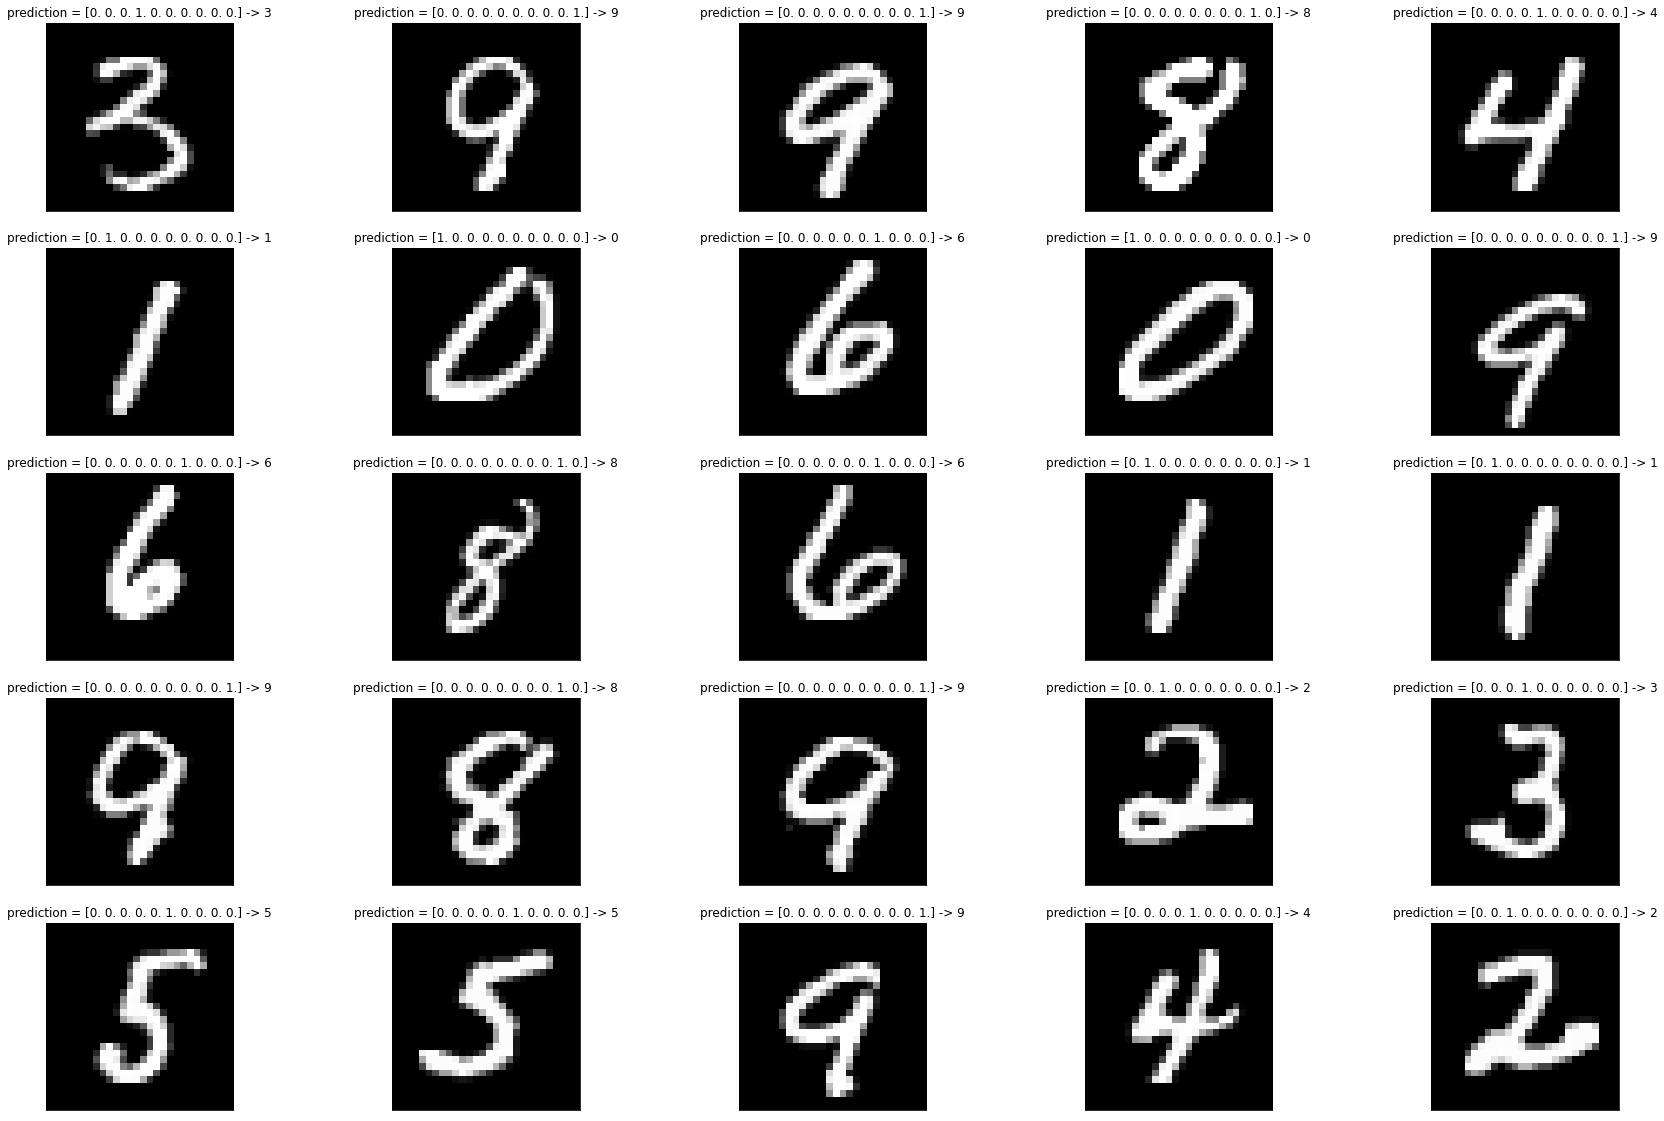

In [2]:
# Plot some results.
plt.rcParams['figure.figsize'] = [30, 20]
fig, axs = plt.subplots(5, 5)
k = 0
for i in range(axs.shape[0]):
    for j in range(axs.shape[1]):
        axs[i, j].imshow(x_test[k, :, :, :].reshape((28, 28)), cmap="gray")
        axs[i, j].set_title("prediction = {0} -> {1}".format(y_test[k], y_test[k].argmax()))
        axs[i, j].set_yticklabels([])
        axs[i, j].set_xticklabels([])
        axs[i, j].set_yticks([])
        axs[i, j].set_xticks([])
        k = k + 1
plt.savefig('predictions.pdf')

In [3]:
# Hyperparameters
count = 40000
validation_split = 0.20
optimizer = 'adadelta'
learning_rate = 1.0
epochs = 10
batch_size = 128
loss = 'binary_crossentropy'
shuffle = True


# Build the model.
input_img = tf.keras.layers.Input(shape=(28, 28, 1))
encoded = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
encoded = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(encoded)
encoded = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
encoded = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(encoded)
encoded = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
encoded = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(encoded)
latent_shape = (int(encoded.shape[1]), int(encoded.shape[2]), int(encoded.shape[3]))
print(latent_shape)
decoded = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
decoded = tf.keras.layers.UpSampling2D((2, 2))(decoded)
decoded = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(decoded)
decoded = tf.keras.layers.UpSampling2D((2, 2))(decoded)
decoded = tf.keras.layers.Conv2D(16, (3, 3), activation='relu')(decoded)
decoded = tf.keras.layers.UpSampling2D((2, 2))(decoded)
decoded = tf.keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(decoded)
autoencoder = tf.keras.models.Model(input_img, decoded)


# Print the model architecture.
autoencoder.summary()


# Define the encoder.
encoder = tf.keras.models.Model(input_img, encoded)


# Define the decoder.
encoded_input = tf.keras.layers.Input(shape=latent_shape)
decoder_layers = len(autoencoder.layers) - len(encoder.layers)
for i in range(decoder_layers, 0, -1):
    decoder_layer = autoencoder.layers[-i]
    if i == decoder_layers:
        nest = decoder_layer(encoded_input)
    else:
        nest = decoder_layer(nest)
decoder = tf.keras.models.Model(encoded_input, nest)


# Compile the autoencoder.
if optimizer == 'adam':
    opt = tf.keras.optimizers.Adam(lr=learning_rate)
if optimizer == 'sgd':
    opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.1)
if optimizer == 'adadelta':
    opt = tf.keras.optimizers.Adadelta(learning_rate=learning_rate)
autoencoder.compile(optimizer=opt, loss=loss)
latent_shape = tuple(encoder.layers[-1].output_shape[1:4])


# Train the autoencoder.
training = autoencoder.fit(x_train, x_train, validation_data=(x_validation, x_validation), epochs=epochs, batch_size=batch_size, shuffle=shuffle)


# Encode and then decode some test data.
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

(4, 4, 8)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 16)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 8)         1160      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 7, 7, 8)          0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 7, 7, 8)       

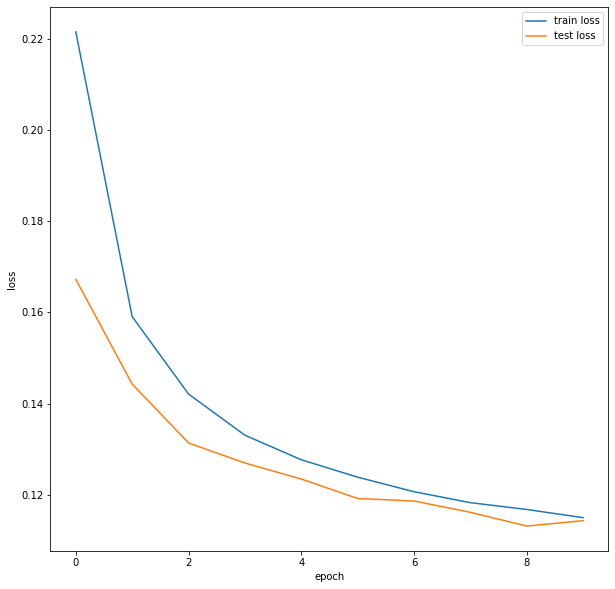

In [4]:
# plotting the training
train_loss = np.array(training.history['loss'])
test_loss = np.array(training.history['val_loss'])
plt.rcParams['figure.figsize'] = [10, 10]
plt.plot(train_loss, label='train loss')
plt.plot(test_loss, label='test loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.savefig('training.pdf')

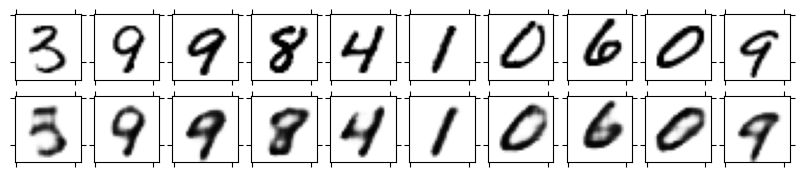

In [5]:
# Plot the decoded test data.
n = 10
vmax = np.max(np.abs(x_test))
vmin = -np.max(np.abs(x_test))
plt.figure(figsize=(10, 2), dpi=100)
for i in range(10):
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i,:,:,0], norm=plt.Normalize(0,vmax), cmap=matplotlib.cm.binary, interpolation='hamming')
    plt.tick_params(axis='both', which='both', bottom='off', top='off', labelbottom='off', right='off', left='off', labelleft='off')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax = plt.subplot(2, n, i+n+1)
    plt.imshow(decoded_imgs[i,:,:,0], norm=plt.Normalize(0,vmax), cmap=matplotlib.cm.binary, interpolation='hamming')
    plt.tick_params(axis='both', which='both', bottom='off', top='off', labelbottom='off', right='off', left='off', labelleft='off')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
plt.savefig('predictions.pdf')

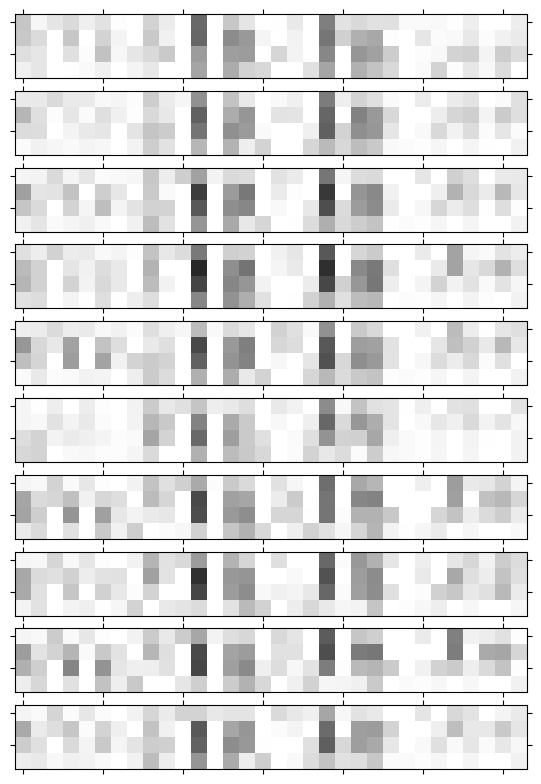

In [6]:
# Plot the latent spaces.
n = 10
vmax = np.max(np.abs(encoded_imgs))
vmin = -np.max(np.abs(encoded_imgs))
plt.figure(figsize=(10, 10), dpi=100)
for i in range(10):
    ax = plt.subplot(n, 1, i + 1)
    plt.imshow(np.reshape(encoded_imgs[i,:,:,:],(latent_shape[0],latent_shape[1]*latent_shape[2])), norm=plt.Normalize(0,vmax), cmap=matplotlib.cm.binary)
    plt.tick_params(axis='both', which='both', bottom='off', top='off', labelbottom='off', right='off', left='off', labelleft='off')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
plt.savefig('latent.pdf')

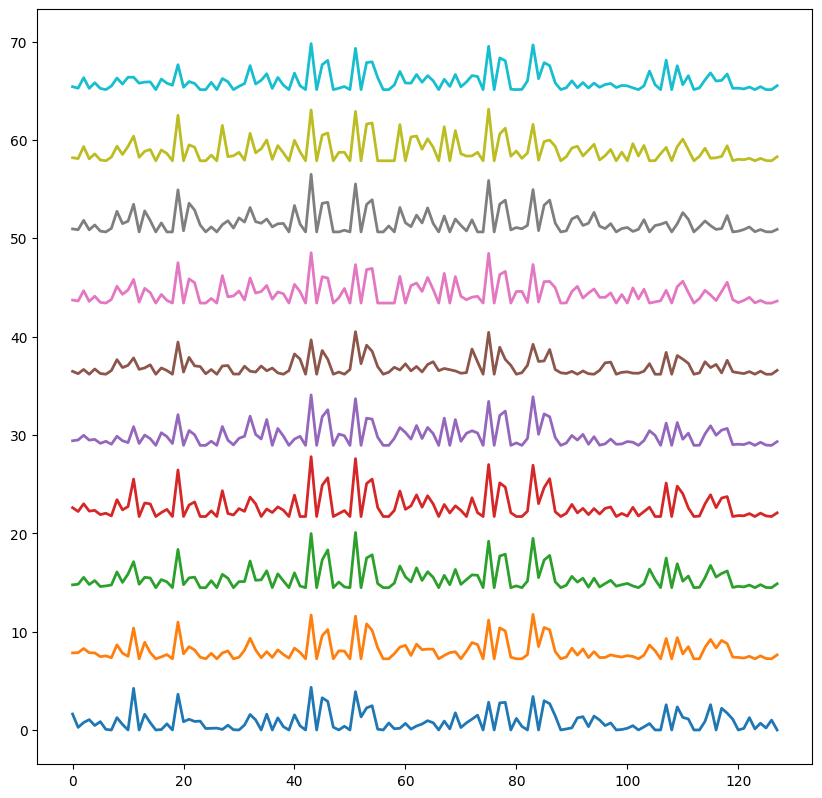

In [7]:
# Plot the flat latent spaces.
n = 10
shift = np.max(encoded_imgs)
plt.figure(figsize=(10, 10), dpi=100)
for i in range(10):
    plt.plot(np.reshape(encoded_imgs[i,:,:,:],(latent_shape[0]*latent_shape[1]*latent_shape[2]))+i*shift, label='${0}$'.format(i), linewidth=2.0)
plt.savefig('latent_flat.pdf')

In [27]:
# Load in the dataset.
V = pickle.load(open('V.db','rb'))
n = pickle.load(open('density.db','rb'))
E = pickle.load(open('E.db','rb'))


# Split the dataset into training, validation and testing data.
V = V.reshape(V.shape + (1,))
n = n.reshape(n.shape + (1,))
E = E.reshape(E.shape + (1,))
V_train = V[:50000]
V_validation = V[50000:75000]
V_test = V[75000:]
V_train = n[:50000]
n_validation = n[50000:75000]
n_test = n[75000:]
E_train = E[:50000]
E_validation = E[50000:75000]
E_test = E[75000:]
print(V.shape, n.shape, E.shape)


# Build the neural network.
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv1D(filters=6, kernel_size=(3), activation="tanh", input_shape=(64, 1)))
model.add(tf.keras.layers.MaxPooling1D())
model.add(tf.keras.layers.Conv1D(filters=16, kernel_size=(3), activation="tanh"))
model.add(tf.keras.layers.MaxPooling1D())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units=120, activation="relu"))
model.add(tf.keras.layers.Dropout(0.9))
model.add(tf.keras.layers.Dense(units=50, activation="tanh"))
model.add(tf.keras.layers.Dropout(0.9))
model.add(tf.keras.layers.Dense(units=1, activation="linear"))


# Complile the model.
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss="mse")


# Train the model.
training = model.fit(V_train, E_train, validation_data=(V_validation, E_validation), epochs=50, batch_size=250, shuffle=True)


# Evaluate the model.
model.evaluate(V_test, E_test, verbose=2)


# Predict using the model.
N = 25 # Number of test images to predict
E_pred = model.predict(V_test[:N, :, :])

(100000, 64, 1) (100000, 64, 1) (100000, 1)
Epoch 1/50
200/200 [==============================] - 1s 3ms/step - loss: 0.1533 - val_loss: 0.1038
Epoch 2/50
200/200 [==============================] - 0s 2ms/step - loss: 0.1039 - val_loss: 0.1309
Epoch 3/50
200/200 [==============================] - 0s 2ms/step - loss: 0.0959 - val_loss: 0.1436
Epoch 4/50
200/200 [==============================] - 0s 2ms/step - loss: 0.0938 - val_loss: 0.1508
Epoch 5/50
200/200 [==============================] - 0s 2ms/step - loss: 0.0921 - val_loss: 0.1603
Epoch 6/50
200/200 [==============================] - 0s 2ms/step - loss: 0.0916 - val_loss: 0.1654
Epoch 7/50
200/200 [==============================] - 0s 2ms/step - loss: 0.0913 - val_loss: 0.1747
Epoch 8/50
200/200 [==============================] - 0s 2ms/step - loss: 0.0902 - val_loss: 0.1780
Epoch 9/50
200/200 [==============================] - 1s 5ms/step - loss: 0.0889 - val_loss: 0.1923
Epoch 10/50
200/200 [==============================] - 1

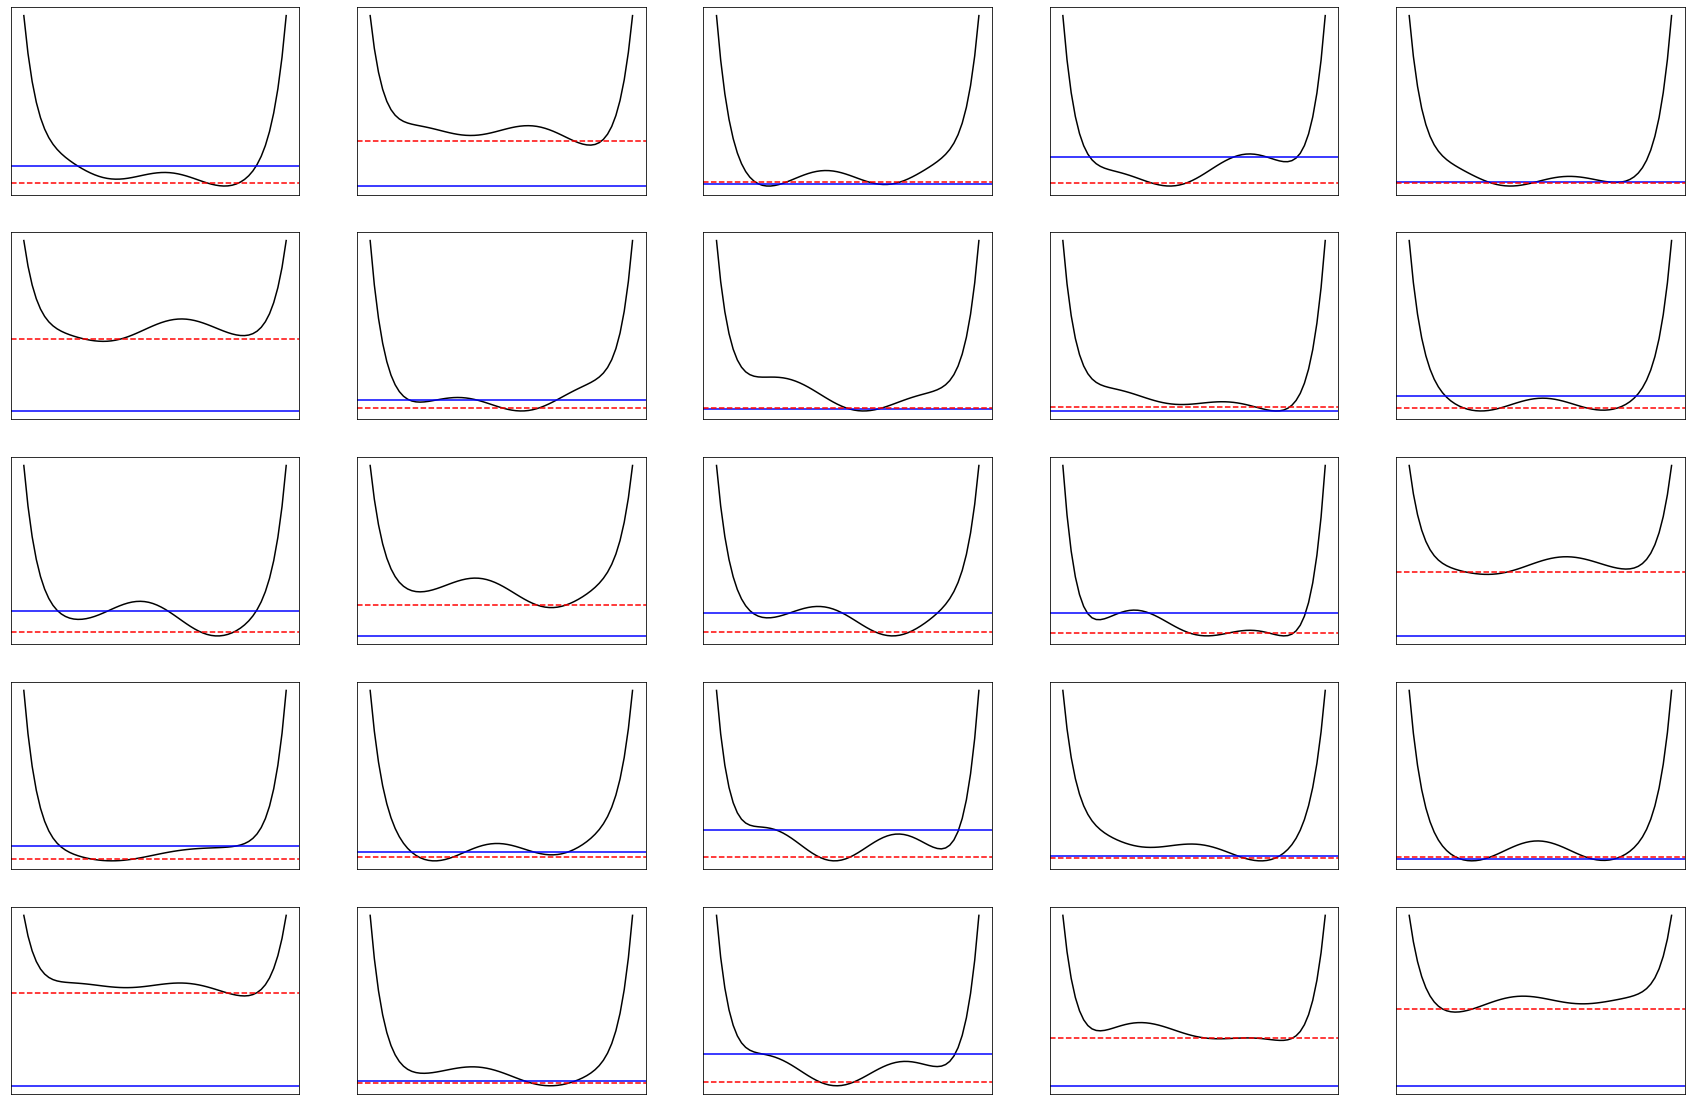

In [18]:
# Plot some results.
plt.rcParams['figure.figsize'] = [30, 20]
fig, axs = plt.subplots(5, 5)
k = 0
for i in range(axs.shape[0]):
    for j in range(axs.shape[1]):
        axs[i, j].plot(V_test[k, :, :].reshape(64,), 'k-')
        axs[i, j].axhline(E_pred[k, 0], color='b')
        axs[i, j].axhline(E_test[k, 0], color='r', linestyle='--')
        axs[i, j].set_yticklabels([])
        axs[i, j].set_xticklabels([])
        axs[i, j].set_yticks([])
        axs[i, j].set_xticks([])
        k = k + 1
plt.savefig('v_predictions.pdf')